# 05 EfficientNet and Custom Pretrained Models

This notebook will cover:
* Using a `PyTorch` model
* Using pre-trained weights for transfer learning
* Setting up a `cnn_learner` style `Learner`

## The Problem:

The problem today will be a familiar one, `PETs`, as we are going to focus on the `Learner` instead

In [ ]:
#Run once per session
!pip install fastai -q --upgrade

In [ ]:
from fastai.vision.all import *

Let's make our usual dataloaders real quick

In [ ]:
path = untar_data(URLs.PETS)/'images'
fnames = get_image_files(path)
pat = r'/([^/]+)_\d+.*'

In [ ]:
batch_tfms = [*aug_transforms(size=224, max_warp=0), Normalize.from_stats(*imagenet_stats)]
item_tfms = RandomResizedCrop(460, min_scale=0.75, ratio=(1.,1.))
bs=64

In [ ]:
pets = DataBlock(blocks=(ImageBlock, CategoryBlock),
                 get_items=get_image_files,
                 splitter=RandomSplitter(),
                 get_y=RegexLabeller(pat = r'/([^/]+)_\d+.*'),
                 item_tfms=item_tfms,
                 batch_tfms=batch_tfms)

In [ ]:
dls = pets.dataloaders(path, bs=bs)

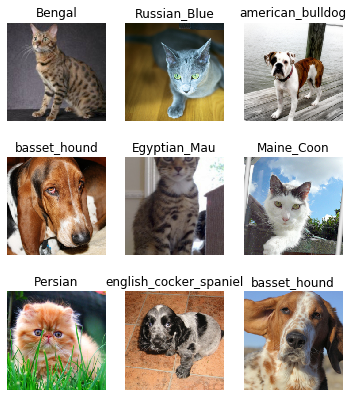

In [ ]:
dls.show_batch(max_n=9, figsize=(6,7))

Now let's focus on our `EfficentNet` model. We'll be working out of Ross Wightman's repository [here](https://github.com/rwightman/pytorch-image-models). Included in this repository is tons of pretrained models for almost every major model in Computer Vision. All were for 224x224 training and validation size. Let's install it

In [ ]:
!pip install timm

     |████████████████████████████████| 143kB 2.8MB/s 


Now we can then use his weights one of two ways. First we'll show the direct way to load it in, then we'll load in the weights ourselves

In [ ]:
from timm import create_model

In [ ]:
net = create_model('efficientnet_b3a', pretrained=True)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b3_ra-a5e2fbc7.pth" to /root/.cache/torch/checkpoints/efficientnet_b3_ra-a5e2fbc7.pth


Now let's take a look at our downloaded model, so we know how to modify it for transfer learning. With fastai models we can do something like so:

In [ ]:
learn = cnn_learner(dls, resnet18)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 65.2MB/s]


In [ ]:
learn.model[-1]

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): full: False
  (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=1024, out_features=512, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=37, bias=False)
)

And we see this head of our model! Let's see if we can do this for our `EfficientNet`

In [ ]:
net[-1]

TypeError: ignored

No! Why?

In [ ]:
len(learn.model)

2

In [ ]:
len(net)

TypeError: ignored

We can see that our `fastai` model was **split** into two different layer groups:

* Group 1: Our encoder, which is everything but the last layer of our original model
* Group 2: Our head, which is a `fastai` version of a `Linear` layer plus a few extra bits

In [ ]:
create_head(2048, 10)

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): full: False
  (2): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=2048, out_features=512, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=10, bias=False)
)

How do we do this for our model? Let's take a look at it:

In [ ]:
net

EfficientNet(
  (conv_stem): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): Swish()
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
        (bn1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): Swish()
        (se): SqueezeExcite(
          (avg_pool): AdaptiveAvgPool2d(output_size=1)
          (conv_reduce): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
          (act1): Swish()
          (conv_expand): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
        )
        (conv_pw): Conv2d(40, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act2): Identity()
      )

We can see that our `Pooling` layer and our `Linear` layer is the last two layers of our model. Let's pop those off

Now if we use the original `fastai` `create_body` function, we'll get an error:

In [ ]:
body = create_body(net, pretrained=False, cut=-1)

TypeError: ignored

Why? Let's take a look

In [ ]:
def create_body(arch, pretrained=True, cut=None):
    "Cut off the body of a typically pretrained `arch` as determined by `cut`"
    model = arch(pretrained=pretrained)
    #cut = ifnone(cut, cnn_config(arch)['cut'])
    if cut is None:
        ll = list(enumerate(model.children()))
        cut = next(i for i,o in reversed(ll) if has_pool_type(o))
    if   isinstance(cut, int): return nn.Sequential(*list(model.children())[:cut])
    elif callable(cut): return cut(model)
    else: raise NamedError("cut must be either integer or a function")

We can see that arch needs to be a **generator**. Let's try to make a function to help us with specifically his library

In [ ]:
def create_timm_body(arch:str, pretrained=True, cut=None):
  model = create_model(arch, pretrained=pretrained)
  if cut is None:
    ll = list(enumerate(model.children()))
    cut = next(i for i,o in reversed(ll) if has_pool_type(o))
  if isinstance(cut, int): return nn.Sequential(*list(model.children())[:cut])
  elif callable(cut): return cut(model)
  else: raise NamedError("cut must be either integer or function")

Let's try it out!

In [ ]:
body = create_timm_body('efficientnet_b3a', pretrained=True)

In [ ]:
len(body)

7

Now we can see that we have seven seperate groups

In [ ]:
body

Sequential(
  (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): Swish()
  (3): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
        (bn1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): Swish()
        (se): SqueezeExcite(
          (avg_pool): AdaptiveAvgPool2d(output_size=1)
          (conv_reduce): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
          (act1): Swish()
          (conv_expand): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
        )
        (conv_pw): Conv2d(40, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act2): Identity()
      )
      (1): Depthwis

But we've popped off the last layers we need! Let's move onto our head of the model. We know the input should be `3072` (we can see this in the last linear layer of the original model). We need it 2x it because of our `AdaptiveConcatPooling` We want it to have an output to our classes. But what if we dont' know that?

In [ ]:
nf = num_features_model(nn.Sequential(*body.children())) * (2); nf

3072

In [ ]:
head = create_head(nf, dls.c)

In [ ]:
head

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): full: False
  (2): BatchNorm1d(3072, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=3072, out_features=512, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=37, bias=False)
)

Now finally we need to wrap it together

In [ ]:
model = nn.Sequential(body, head)

And then we initialize our new head of our model

In [ ]:
apply_init(model[1], nn.init.kaiming_normal_)

Now we have our two layer-long model! What's next?

In [ ]:
len(model)

2

Let's try making a `Learner`

In [ ]:
learn = Learner(dls, model, loss_func=LabelSmoothingCrossEntropy())

In [ ]:
learn.summary()

Sequential (Input shape: ['64 x 3 x 224 x 224'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               64 x 40 x 112 x 112  1,080      True      
________________________________________________________________
BatchNorm2d          64 x 40 x 112 x 112  80         True      
________________________________________________________________
Swish                64 x 40 x 112 x 112  0          False     
________________________________________________________________
Conv2d               64 x 40 x 112 x 112  360        True      
________________________________________________________________
BatchNorm2d          64 x 40 x 112 x 112  80         True      
________________________________________________________________
Swish                64 x 40 x 112 x 112  0          False     
________________________________________________________________
AdaptiveAvgPool2d    64 x 40 x 1 x 1      0          False     
_________________________________________________

Oh no! It isn't frozen, what do we do? We never split the model! Since we have it set to where `model[0]` is the first group and `model[1]` is the second group, we can use the `default_split` splitter. Let's try again

In [ ]:
learn = Learner(dls, model, loss_func=LabelSmoothingCrossEntropy(), 
                splitter=default_split, metrics=error_rate)

In [ ]:
learn.freeze()
learn.summary()

Sequential (Input shape: ['64 x 3 x 224 x 224'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               64 x 40 x 112 x 112  1,080      False     
________________________________________________________________
BatchNorm2d          64 x 40 x 112 x 112  80         True      
________________________________________________________________
Swish                64 x 40 x 112 x 112  0          False     
________________________________________________________________
Conv2d               64 x 40 x 112 x 112  360        False     
________________________________________________________________
BatchNorm2d          64 x 40 x 112 x 112  80         True      
________________________________________________________________
Swish                64 x 40 x 112 x 112  0          False     
________________________________________________________________
AdaptiveAvgPool2d    64 x 40 x 1 x 1      0          False     
_________________________________________________

That looks much better. Let's train!

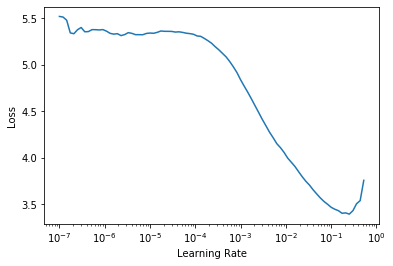

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(5, slice(3e-2))

epoch,train_loss,valid_loss,error_rate,time
0,1.935569,1.548306,0.198917,00:38
1,1.360869,1.022956,0.100135,00:37
2,1.070680,0.958684,0.085250,00:37
3,0.941763,0.930160,0.080514,00:37
4,0.876002,0.905405,0.071719,00:37


In [ ]:
learn.save('stage_1')

Then we can unfreeze it and train a little more

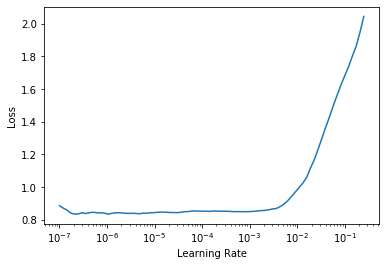

In [ ]:
learn.unfreeze()
learn.lr_find()

In [ ]:
learn.fit_one_cycle(5, 1e-4)

epoch,train_loss,valid_loss,error_rate,time
0,0.856545,0.891247,0.066306,00:50
1,0.835565,0.874920,0.054804,00:50
2,0.801183,0.863947,0.051421,00:50
3,0.779860,0.863559,0.056157,00:50
4,0.772397,0.860884,0.052774,00:50


In [ ]:
learn.save('model_2')

One of the hardest parts about training the `EfficientNet` models is figuring out how to find the right learning rate that won't break everything, so choose cautiously and always a bit lower than what you may want to use after unfreezing

We barely under-matched our Resnet34, **but** we're using a model that is **57%** the size of the Resnet34!

# Pretrained PKL File

Let's say we have a different situation:

* No "pretrained=True"
* Have downloaded weights

* Possible scenarios:
  * Experimenting with a model 
  * Transfer learning twice

How do we do it? Let's take our Cats and Dogs model and train ImageWoof off of it

In [ ]:
path = untar_data(URLs.IMAGEWOOF)
tfms = [[PILImage.create], [parent_label, Categorize()]]
item_tfms = [ToTensor(), Resize(128)]
batch_tfms = [FlipItem(), RandomResizedCrop(128, min_scale=0.35),
              IntToFloatTensor(), Normalize.from_stats(*imagenet_stats)]

In [ ]:
items = get_image_files(path)
split_idx = GrandparentSplitter(valid_name='val')(items)
dsets = Datasets(items, tfms, splits=split_idx)
dls = dsets.dataloaders(after_item=item_tfms, after_batch=batch_tfms, bs=64)

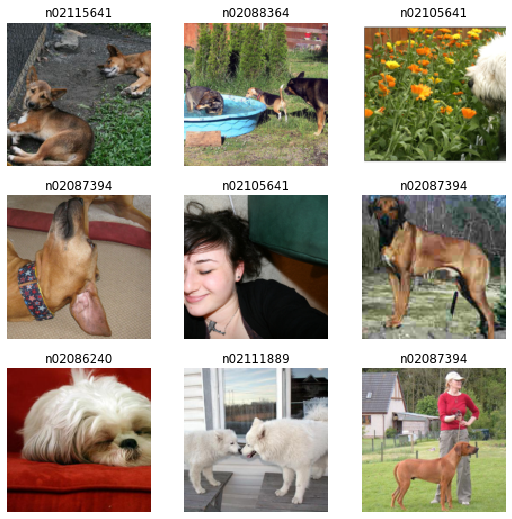

In [ ]:
dls.show_batch()

Let's walk through how we would do that. First let's grab our model and make our `Learner` like we did before, with **everything** but the pretraining!

In [ ]:
body = create_timm_body('efficientnet_b3a', pretrained=False)
head = create_head(3072, dls.c)
model = nn.Sequential(body, head)
apply_init(model[1], nn.init.kaiming_normal_)

In [ ]:
learn = Learner(dls, model, loss_func=LabelSmoothingCrossEntropy(), 
                splitter=default_split, metrics=accuracy)

Now, remember these are all random weights right now. How do we change this? We look at the `state_dict`

In [ ]:
learn.model.state_dict()

The state dict tells us the parameters and weights at **every** layer. Now to work with it, we'll borrow some code from [viraat](https://forums.fast.ai/t/loading-pretrained-weights-that-are-not-from-imagenet/28821/3). Basically what we want to do is:
1. Keep two state_dict's, one of our new model and one of the old
2. If a layer matches, copy the weights
3. Move until there are no more layers
4. Finally load the new state_dict generated

In [ ]:
learn.model_dir

'models'

In [ ]:
def transfer_learn(learn:Learner, name:Path, device:torch.device=None):
    "Load model `name` from `self.model_dir` using `device`, defaulting to `self.dls.device`."
    if device is None: device = learn.dls.device
    learn.model_dir = Path(learn.model_dir)
    if (learn.model_dir/name).with_suffix('.pth').exists(): model_path = (learn.model_dir/name).with_suffix('.pth')
    else: model_path = name
    new_state_dict = torch.load(model_path, map_location=device)['model']
    learn_state_dict = learn.model.state_dict()
    for name, param in learn_state_dict.items():
        if name in new_state_dict:
            input_param = new_state_dict[name]
            if input_param.shape == param.shape:
                param.copy_(input_param)
            else:
                print('Shape mismatch at:', name, 'skipping')
        else:
            print(f'{name} weight of the model not in pretrained weights')
    learn.model.load_state_dict(learn_state_dict)
    return learn

Now let's load some in!

In [ ]:
learn = transfer_learn(learn, 'stage_1')

Shape mismatch at: 1.8.weight skipping


In [ ]:
learn.model[1][8]

Linear(in_features=512, out_features=10, bias=False)

And we can see the only weight that wasn't loaded in was our new layer! Let's freeze and train our model

In [ ]:
learn.freeze()

Let's see if it worked. We'll do a comparison test, 5 epochs without our `transfer_learn` and five with

In [ ]:
learn.fit_one_cycle(5, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.282371,0.934233,0.832018,00:37
1,0.912630,0.814222,0.883685,00:38
2,0.811893,0.780937,0.893357,00:38
3,0.759423,0.770062,0.896920,00:38
4,0.730576,0.767888,0.898193,00:39


And now let's try on a regular non-transfered learner (at the same learning rate, frozen, etc)

In [ ]:
body = create_timm_body('efficientnet_b3a', pretrained=False)
head = create_head(3072, dls.c)
model = nn.Sequential(body, head)
apply_init(model[1], nn.init.kaiming_normal_)
learn = Learner(dls, model, loss_func=LabelSmoothingCrossEntropy(), 
                splitter=default_split, metrics=accuracy)
learn.freeze()
learn.fit_one_cycle(5, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,2.869522,2.830859,0.114024,00:38
1,2.684337,2.571606,0.124714,00:38
2,2.543600,2.666231,0.135912,00:38
3,2.485797,2.387705,0.146602,00:38
4,2.430820,2.360096,0.154238,00:38
